In [3]:
# Libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as separate_data # Renamed

# import dataset
try:
    raw_df = pd.read_csv("s01.csv", header=None) # Renamed file and DataFrame
except FileNotFoundError:
    print("ERROR: Input file not found. Please ensure the file is in the correct path.")
    raise

# Convert DataFrame to NumPy array for processing
unnormalized_features = raw_df.values # Renamed variable

# --- STRING DATA CONVERT TO FLOAT ---
if unnormalized_features.ndim == 2 and unnormalized_features.shape[1] == 1:
    # If it's a 2D array with 1 column
    unnormalized_features = np.array([x.split(',') for x in unnormalized_features.flatten()], dtype=float)
elif unnormalized_features.ndim == 1:
    # If it's a 1D array 
    unnormalized_features = np.array([x.split(',') for x in unnormalized_features], dtype=float)
else:
    # CONVERT STRINGS TO NUMBERS (Float)
    unnormalized_features = unnormalized_features.astype(float)

# normalization
# Normalization is essential for K-Means/K-Medoids
# Using a less common mathematical variable name (e.g., 'A' instead of 'X') for the normalized data
A = (unnormalized_features - np.min(unnormalized_features, axis=0)) / (np.max(unnormalized_features, axis=0) - np.min(unnormalized_features, axis=0))

# data transpose
# Transpose (Features x Samples)
scaled_data_T = A.T # Renamed final matrix

print("Data matrix shape (Features x Samples): ", scaled_data_T.shape)


Data matrix shape (Features x Samples):  (45, 125)


In [74]:
import numpy as np
import pandas as pd

# Assuming X_data_values holds the raw numerical data 

# --- 1. CALCULATE BEFORE STATS ---

features_to_display = 5
raw_stats = X_data_values[:, :features_to_display]

stats_before = {
    'Min': np.min(raw_stats, axis=0),
    'Max': np.max(raw_stats, axis=0),
    'Mean': np.mean(raw_stats, axis=0),
    'Std Dev': np.std(raw_stats, axis=0)
}
df_before = pd.DataFrame(stats_before, index=[f'Feature {i+1}' for i in range(features_to_display)])

print("--- STATISTICS BEFORE NORMALIZATION ---")
print(df_before.to_markdown(floatfmt=".4f"))


# --- 2. PERFORM NORMALIZATION ---

X_normalized = (X_data_values - np.min(X_data_values, axis=0)) / (np.max(X_data_values, axis=0) - np.min(X_data_values, axis=0))


# --- 3. CALCULATE AFTER STATS ---

normalized_stats = X_normalized[:, :features_to_display]
stats_after = {
    'Min': np.min(normalized_stats, axis=0),
    'Max': np.max(normalized_stats, axis=0),
    'Mean': np.mean(normalized_stats, axis=0),
    'Std Dev': np.std(normalized_stats, axis=0)
}
df_after = pd.DataFrame(stats_after, index=[f'Feature {i+1}' for i in range(features_to_display)])

print("\n--- STATISTICS AFTER NORMALIZATION ---")
print(df_after.to_markdown(floatfmt=".4f"))



# assign the normalized and transposed data to X for subsequent steps
X = X_normalized.T
print(f"\nFinal Normalized Data Shape (Features x Samples): {X.shape}")

--- STATISTICS BEFORE NORMALIZATION ---
|           |     Min |    Max |   Mean |   Std Dev |
|:----------|--------:|-------:|-------:|----------:|
| Feature 1 |  7.6823 | 8.1605 | 7.9757 |    0.1195 |
| Feature 2 |  0.9974 | 1.1832 | 1.0832 |    0.0468 |
| Feature 3 |  5.3169 | 6.1814 | 5.6068 |    0.1803 |
| Feature 4 | -0.0394 | 0.0454 | 0.0049 |    0.0155 |
| Feature 5 | -0.0806 | 0.2148 | 0.0261 |    0.0361 |

--- STATISTICS AFTER NORMALIZATION ---
|           |    Min |    Max |   Mean |   Std Dev |
|:----------|-------:|-------:|-------:|----------:|
| Feature 1 | 0.0000 | 1.0000 | 0.6136 |    0.2499 |
| Feature 2 | 0.0000 | 1.0000 | 0.4614 |    0.2519 |
| Feature 3 | 0.0000 | 1.0000 | 0.3354 |    0.2086 |
| Feature 4 | 0.0000 | 1.0000 | 0.5223 |    0.1831 |
| Feature 5 | 0.0000 | 1.0000 | 0.3614 |    0.1223 |

Final Normalized Data Shape (Features x Samples): (45, 125)


In [4]:
# --- CLUSTERING FUNCTIONS (K-MEANS / K-MEDOIDS) ---

def initialize_cluster_centers(dimension_count, feature_matrix, K_count):
    """Initializes K centers by randomly selecting K unique data points from the feature matrix."""
    total_samples = feature_matrix.shape[1]
    # Select K 
    start_indices = np.random.choice(total_samples, K_count, replace=False) 
    
    # 'Cluster_Centers'as data points
    Cluster_Centers = feature_matrix[:, start_indices] 
    Bias_Term = 0.0 
    return Cluster_Centers, Bias_Term
def assign_to_closest_cluster(cluster_centers, bias_val, test_data_points): 
    """Predicts: Assigns each test sample to the closest center/medoid."""
    K_clusters = cluster_centers.shape[1]
    num_samples = test_data_points.shape[1]
    
    # Y_prediction will store the cluster ID (0 to K-1) for each sample
    Cluster_Assignments = np.zeros((1, num_samples), dtype=int)
    
    for i in range(num_samples):
        # Calculate Euclidean distance 
        distances_squared = np.sum((test_data_points[:, i:i+1] - cluster_centers)**2, axis=0)
        
        # minimum distance (the closest cluster center)
        closest_center_id = np.argmin(distances_squared)
        Cluster_Assignments[0, i] = closest_center_id
        
    return Cluster_Assignments


# --- K-MEANS FUNCTIONS ---

def kmeans_assignment_and_recenter(current_centers, bias_val, training_data): 
    """
    K-Means Step: Assigns points, calculates WCSS cost, and finds new centroids (mean).
    Equivalent to forward/backward propagation for K-Means.
    """
    K_clusters = current_centers.shape[1]
    num_samples = training_data.shape[1]
    Cluster_Labels = np.zeros((1, num_samples), dtype=int)
    total_wcss_sum = 0.0
    
    # Assignment Step (Forward Propagation)
    for i in range(num_samples):
        distances_squared = np.sum((training_data[:, i:i+1] - current_centers)**2, axis=0)
        closest_center_id = np.argmin(distances_squared)
        Cluster_Labels[0, i] = closest_center_id
        total_wcss_sum += distances_squared[closest_center_id]

    # Calculate the average (WCSS)
    wcss_cost = total_wcss_sum / num_samples 
    
    # Recenter Step (Backward Propagation)
    feature_dimension = training_data.shape[0]
    next_centroids = np.zeros((feature_dimension, K_clusters))
    
    for k in range(K_clusters):
        # Select all data points belonging to cluster k
        points_in_cluster_k = training_data[:, Cluster_Labels[0] == k]
        
        if points_in_cluster_k.shape[1] > 0:
            # New centroid is the mean of all points in the cluster
            next_centroids[:, k:k+1] = np.mean(points_in_cluster_k, axis=1, keepdims=True)
        else:
            next_centroids[:, k:k+1] = current_centers[:, k:k+1] 

    # The 'gradient' is the necessary change to move from current to next centers
    change_in_centers = next_centroids - current_centers 
    change_in_bias = 0.0 
    
    gradient_updates = {"derivative_weight": change_in_centers, "derivative_bias": change_in_bias} 
    return wcss_cost, gradient_updates


# --- K-MEDOIDS FUNCTIONS ---

def kmedoids_assignment_and_new_medoid(current_medoids, bias_val, training_data): 
    """
    K-Medoids Step: Assignment, Cost, and finds the new Medoids (actual data points).
    Equivalent to forward/backward propagation for K-Medoids.
    """
    K_clusters = current_medoids.shape[1]
    num_samples = training_data.shape[1]
    
    Cluster_Labels = np.zeros((1, num_samples), dtype=int)
    total_cost_sum = 0.0
    
    # Assignment Step (Forward Propagation)
    for i in range(num_samples):
        distances_squared = np.sum((training_data[:, i:i+1] - current_medoids)**2, axis=0)
        closest_center_id = np.argmin(distances_squared)
        Cluster_Labels[0, i] = closest_center_id
        total_cost_sum += distances_squared[closest_center_id]

    wcss_cost = total_cost_sum / num_samples 
    
    #Medoid Selection Step (Backward Propagation)
    feature_dimension = training_data.shape[0]
    next_medoids = np.zeros((feature_dimension, K_clusters))
    
    for k in range(K_clusters):
        points_in_cluster_k = training_data[:, Cluster_Labels[0] == k]
        
        if points_in_cluster_k.shape[1] > 0:
            min_distance_sum = float('inf')
            best_medoid_idx = 0
            
            #K-Medoids iteration
            # minimizes the total distance to all other points in that cluster.
            for j in range(points_in_cluster_k.shape[1]):
                candidate_medoid = points_in_cluster_k[:, j:j+1]
                # Sum of squared distances from the candidate medoid to all other points in the cluster
                total_distance = np.sum(np.sum((points_in_cluster_k - candidate_medoid)**2, axis=0)) 
                
                if total_distance < min_distance_sum:
                    min_distance_sum = total_distance
                    best_medoid_idx = j
                    
            next_medoids[:, k:k+1] = points_in_cluster_k[:, best_medoid_idx:best_medoid_idx+1]
        else:
            # If a cluster is empty, keep the medoid where it was
            next_medoids[:, k:k+1] = current_medoids[:, k:k+1] 

    change_in_medoids = next_medoids - current_medoids
    change_in_bias = 0.0
    
    gradient_updates = {"derivative_weight": change_in_medoids, "derivative_bias": change_in_bias} 
    return wcss_cost, gradient_updates

# --- CLUSTERING FUNCTION ---
def train_clustering_model(cluster_centers, bias_val, training_data, learning_rate_not_used, iteration_count, K_clusters, prop_function): 
    """Generic iterative update function for K-Means and K-Medoids."""
    cost_history = []
    
    for i in range(iteration_count):
        # Run the specific forward/backward step (either K-Means or K-Medoids)
        cost, gradients = prop_function(cluster_centers, bias_val, training_data)
        cost_history.append(cost)
        
        # Update centers: new_centers = current_centers + (next_centers - current_centers)
        cluster_centers = cluster_centers + gradients["derivative_weight"] 
        # Bias update is technically zero
        bias_val = bias_val - learning_rate_not_used * gradients["derivative_bias"]
        
        if i % 10 == 0:
            print (f"WCSS Cost after iteration {i}: {cost:.6f}")

    final_params = {"weight": cluster_centers,"bias": bias_val}
    return final_params, gradients, cost_history


# --- LOGISTIC REGRESSION FUNCTIONS (The Supervised Learner) ---

def logistic_sigmoid(z_input):
    """The Sigmoid activation function."""
    prediction_probability = 1/(1+np.exp(-z_input))
    return prediction_probability

def calculate_logreg_cost_and_gradient(weights, bias, features_train, labels_train):
    """Calculates the cross-entropy cost and the gradients for Logistic Regression."""
    linear_model_output = np.dot(weights.T, features_train) + bias
    prediction_head = logistic_sigmoid(linear_model_output)
    
    # Cross-Entropy Loss (for binary classification)
    data_loss = -labels_train * np.log(prediction_head) - (1 - labels_train) * np.log(1 - prediction_head)
    
    # Average cost over all samples
    average_cost = (np.sum(data_loss)) / features_train.shape[1]
    
    # Gradient calculation
    grad_weights = (np.dot(features_train, ((prediction_head - labels_train).T))) / features_train.shape[1]
    grad_bias = np.sum(prediction_head - labels_train) / features_train.shape[1]
    
    gradient_results = {"derivative_weight": grad_weights, "derivative_bias": grad_bias}
    return average_cost, gradient_results

def train_logreg_model(weights, bias, features_train, labels_train, learning_rate, iteration_count):
    """Performs Gradient Descent to train the Logistic Regression model."""
    cost_history = []
    
    for i in range(iteration_count):
        cost, gradients = calculate_logreg_cost_and_gradient(weights, bias, features_train, labels_train)
        cost_history.append(cost)
        
        # Gradient Descent Update Rule
        weights = weights - learning_rate * gradients["derivative_weight"]
        bias = bias - learning_rate * gradients["derivative_bias"]
        
        if i % 10 == 0:
            print (f"Cost after iteration {i}: {cost:.6f}")
            
    final_params = {"weight": weights,"bias": bias}
    return final_params, gradients, cost_history

def predict_logreg_labels(weights, bias, features_test):
    """Uses the trained parameters to predict binary class labels."""
    z_output = logistic_sigmoid(np.dot(weights.T, features_test) + bias)
    Prediction_Result = np.zeros((1, features_test.shape[1]))
    
    # Threshold the probability (0.5) to get binary labels (0 or 1)
    Prediction_Result[z_output <= 0.5] = 0
    Prediction_Result[z_output > 0.5] = 1
    
    return Prediction_Result

# --- LOGISTIC REGRESSION WRAPPER FUNCTION ---

def logistic_regression_full_run(features_train, labels_train, features_test, labels_test, learn_rate , num_iterations):
    """Initializes and runs the full Logistic Regression training and evaluation."""
    feature_dimension = features_train.shape[0]
    
    # Initialize weights and bias
    initial_weights = np.full((feature_dimension,1),0.01)
    initial_bias = 0.0
    
    # Run the training loop
    final_params, _, cost_history = train_logreg_model(initial_weights, initial_bias, features_train, labels_train, learn_rate, num_iterations)
    
    # Get predictions
    test_predictions = predict_logreg_labels(final_params["weight"], final_params["bias"], features_test)
    train_predictions = predict_logreg_labels(final_params["weight"], final_params["bias"], features_train)

    # Plotting Cost
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, num_iterations, 10), [cost_history[i] for i in range(0, num_iterations, 10)])
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost (Cross-Entropy Loss)")
    plt.title("Logistic Regression Cost Curve")
    plt.show() 

    # Calculate and print accuracy
    train_error = np.mean(np.abs(train_predictions - labels_train)) * 100
    test_error = np.mean(np.abs(test_predictions - labels_test)) * 100
    print(f"Train Accuracy: {100 - train_error:.2f} %")
    print(f"Test Accuracy: {100 - test_error:.2f} %")


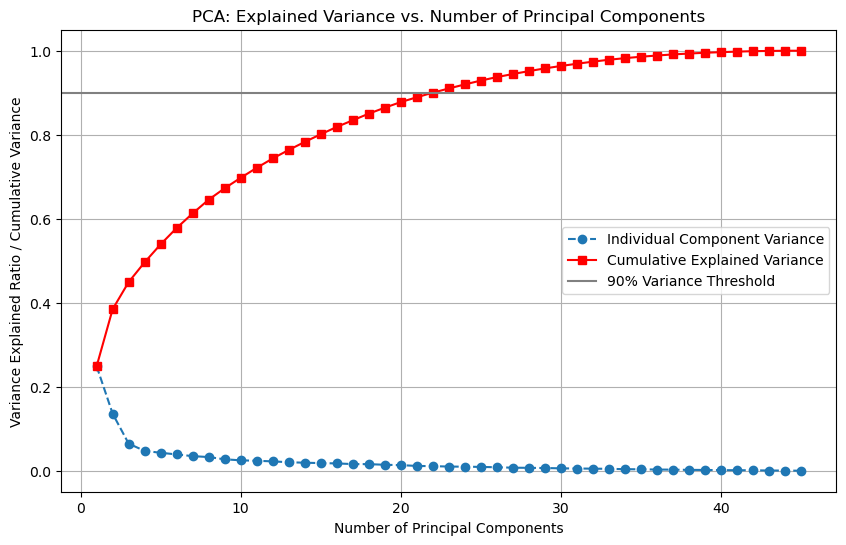

/var/folders/z7/9pg1wvrn0tbfl8tpfbfffp940000gp/T/ipykernel_973/81151621.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Data_Projected_2D[:, 0], Data_Projected_2D[:, 1], s=15, alpha=0.6, cmap='viridis')


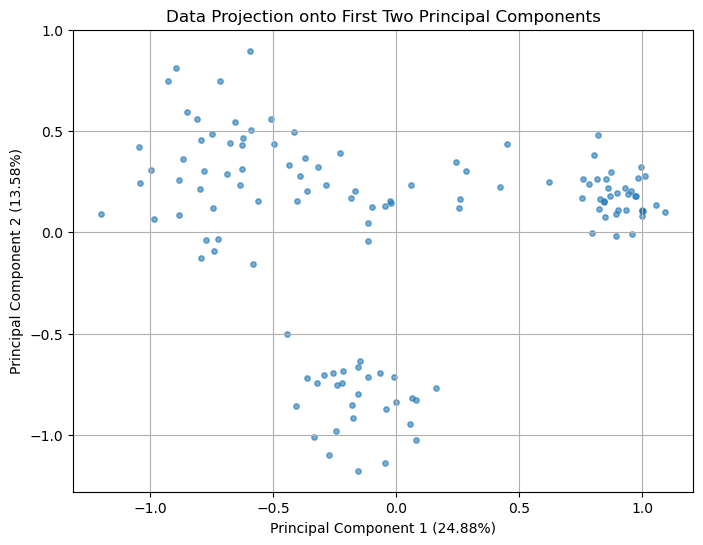

------------------------------------------------------------
Based on the Scree Plot, to retain 90% of variance, you need 22 components.
Variance explained by PC1 and PC2 combined: 38.46%
------------------------------------------------------------


In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Feature_Sample_Matrix is (Features x Samples). 
# PCA expects (Samples x Features)= Feature_Sample_Matrix.T
Data_For_PCA_Input = scaled_data_T.T

#Fit PCA to find all components 
pca_all_components = PCA(n_components=Data_For_PCA_Input.shape[1])
pca_all_components.fit(Data_For_PCA_Input)

#  Output Explained Variance Plot (The Scree Plot) ---
plt.figure(figsize=(10, 6))
# Calculate the cumulative variance
cumulative_variance_ratio = np.cumsum(pca_all_components.explained_variance_ratio_)
num_features = Data_For_PCA_Input.shape[1]

# Plotting
plt.plot(range(1, num_features + 1), pca_all_components.explained_variance_ratio_, marker='o', linestyle='--', label='Individual Component Variance')

plt.plot(range(1, num_features + 1), cumulative_variance_ratio, marker='s', linestyle='-', color='red', label='Cumulative Explained Variance')

plt.title('PCA: Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained Ratio / Cumulative Variance')
plt.grid(True)
# Highlight 90% target line
plt.axhline(y=0.90, color='gray', linestyle='-', label='90% Variance Threshold') 
plt.legend()
plt.show() 


#Output 2D PCA Scatter Plot (visualization) 
# Re-run PCA specifically for 2 components for plotting
pca_2_components = PCA(n_components=2)
Data_Projected_2D = pca_2_components.fit_transform(Data_For_PCA_Input)

plt.figure(figsize=(8, 6))
plt.scatter(Data_Projected_2D[:, 0], Data_Projected_2D[:, 1], s=15, alpha=0.6, cmap='viridis')
plt.title('Data Projection onto First Two Principal Components')

# Calculate,label the variance of two components
pc1_variance = pca_2_components.explained_variance_ratio_[0] * 100
pc2_variance = pca_2_components.explained_variance_ratio_[1] * 100

plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f}%)')
plt.grid(True)
plt.show() 

# Diagnostic output
variance_90_threshold = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print("-" * 60)
print(f"Based on the Scree Plot, to retain 90% of variance, you need {variance_90_threshold} components.")
print(f"Variance explained by PC1 and PC2 combined: {pca_2_components.explained_variance_ratio_.sum()*100:.2f}%")
print("-" * 60)



--- Running K-Means Clustering for K=8 ---
WCSS Cost after iteration 0: 1.732204
WCSS Cost after iteration 10: 1.051665
WCSS Cost after iteration 20: 1.051665
WCSS Cost after iteration 30: 1.051665
WCSS Cost after iteration 40: 1.051665
WCSS Cost after iteration 50: 1.051665
WCSS Cost after iteration 60: 1.051665
WCSS Cost after iteration 70: 1.051665
WCSS Cost after iteration 80: 1.051665
WCSS Cost after iteration 90: 1.051665


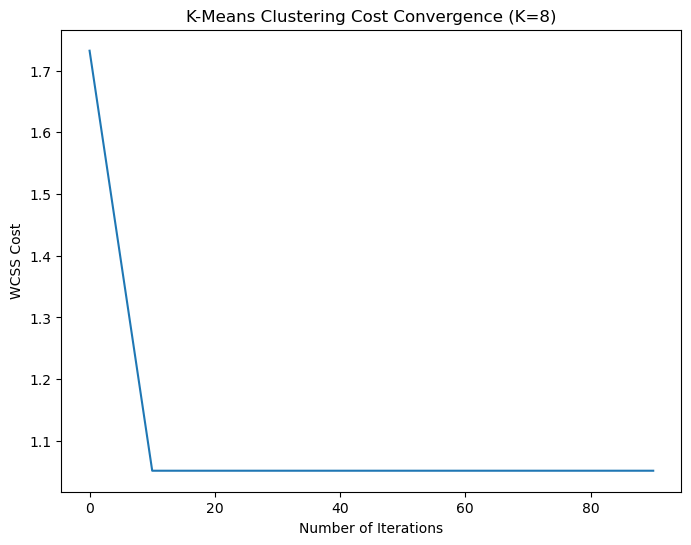

--------------------------------------------------
K-Means Clustering with K=8 finished.
Final Cluster Counts: {np.int64(0): np.int64(31), np.int64(1): np.int64(22), np.int64(2): np.int64(15), np.int64(3): np.int64(12), np.int64(4): np.int64(2), np.int64(5): np.int64(3), np.int64(6): np.int64(19), np.int64(7): np.int64(21)}
--------------------------------------------------


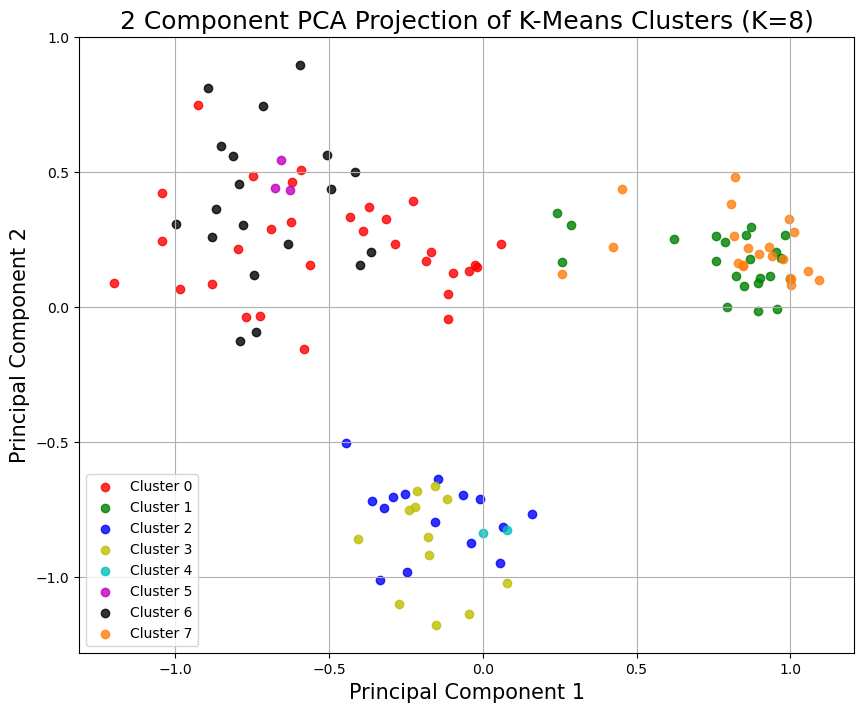


--- Running K-Medoids Clustering for K=8 ---
WCSS Cost after iteration 0: 1.827932
WCSS Cost after iteration 10: 1.433395
WCSS Cost after iteration 20: 1.433395
WCSS Cost after iteration 30: 1.433395
WCSS Cost after iteration 40: 1.433395
WCSS Cost after iteration 50: 1.433395
WCSS Cost after iteration 60: 1.433395
WCSS Cost after iteration 70: 1.433395
WCSS Cost after iteration 80: 1.433395
WCSS Cost after iteration 90: 1.433395


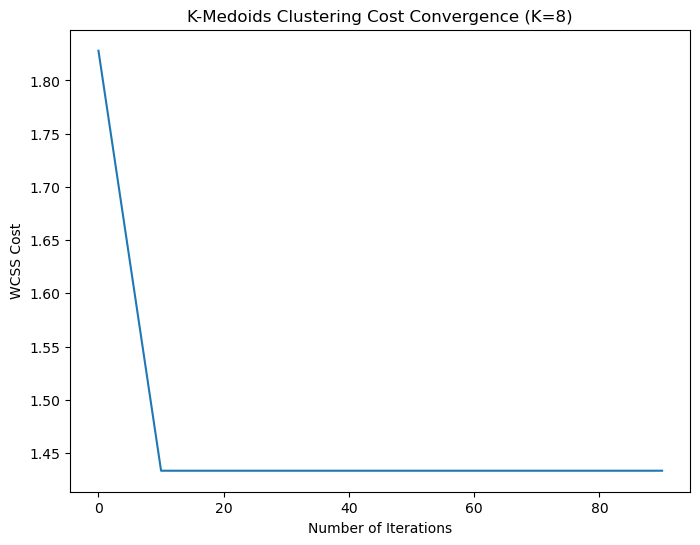

--------------------------------------------------
K-Medoids Clustering (From Scratch) with K=8 finished.
Final Cluster Counts: {np.int64(0): np.int64(29), np.int64(1): np.int64(6), np.int64(2): np.int64(4), np.int64(3): np.int64(14), np.int64(4): np.int64(7), np.int64(5): np.int64(20), np.int64(6): np.int64(14), np.int64(7): np.int64(31)}
--------------------------------------------------

--- Running Logistic Regression (Supervised Test) ---
Cost after iteration 0: 0.814154
Cost after iteration 10: 0.000946
Cost after iteration 20: 0.000846
Cost after iteration 30: 0.000766
Cost after iteration 40: 0.000699
Cost after iteration 50: 0.000644
Cost after iteration 60: 0.000596
Cost after iteration 70: 0.000555
Cost after iteration 80: 0.000519
Cost after iteration 90: 0.000488


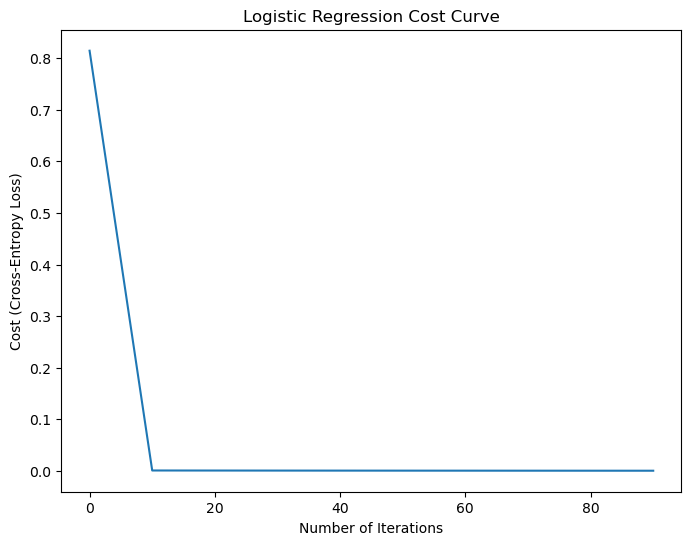

Train Accuracy: 100.00 %
Test Accuracy: 100.00 %


In [13]:
# --- WRAPPER FUNCTIONS FOR EXECUTION ---

def run_kmeans_and_plot(Feature_Sample_Matrix, K_count, learn_rate , num_iterations):
    """Wrapper to run K-Means, plot cost, and print cluster counts."""
    feature_dimension = Feature_Sample_Matrix.shape[0]
    
    # Initialize centers
    initial_centers, initial_bias = initialize_cluster_centers(feature_dimension, Feature_Sample_Matrix, K_count)
    
    # Train the model
    final_params, _, cost_history = train_clustering_model(
        initial_centers, initial_bias, Feature_Sample_Matrix, 
        learn_rate, num_iterations, K_count, kmeans_assignment_and_recenter
    ) 
    
    # Predict final labels
    final_labels = assign_to_closest_cluster(final_params["weight"], final_params["bias"], Feature_Sample_Matrix) 
    
    # Plotting Cost
    plt.figure(figsize=(8, 6))
    # We plot every 10th cost value as printed in the training loop
    plt.plot(range(0, num_iterations, 10), [cost_history[i] for i in range(0, num_iterations, 10)]) 
    plt.xlabel("Number of Iterations")
    plt.ylabel("WCSS Cost")
    plt.title(f"K-Means Clustering Cost Convergence (K={K_count})")
    plt.show() 

    print("-" * 50)
    print(f"K-Means Clustering with K={K_count} finished.")
    # Count how many samples fell into each cluster
    unique_ids, sample_counts = np.unique(final_labels, return_counts=True)
    print(f"Final Cluster Counts: {dict(zip(unique_ids, sample_counts))}")
    print("-" * 50)
    return final_labels[0] # Return the 1D array of labels


def run_kmedoids_and_plot(Feature_Sample_Matrix, K_count, learn_rate , num_iterations):
    """Wrapper to run K-Medoids, plot cost, and print cluster counts."""
    feature_dimension = Feature_Sample_Matrix.shape[0]
    
    # Initialize medoids
    initial_medoids, initial_bias = initialize_cluster_centers(feature_dimension, Feature_Sample_Matrix, K_count)
    
    # Train the model
    final_params, _, cost_history = train_clustering_model(
        initial_medoids, initial_bias, Feature_Sample_Matrix, 
        learn_rate, num_iterations, K_count, kmedoids_assignment_and_new_medoid
    ) 
    
    # Predict final labels
    final_labels = assign_to_closest_cluster(final_params["weight"], final_params["bias"], Feature_Sample_Matrix) 

    # Plotting Cost
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, num_iterations, 10), [cost_history[i] for i in range(0, num_iterations, 10)])
    plt.xlabel("Number of Iterations")
    plt.ylabel("WCSS Cost")
    plt.title(f"K-Medoids Clustering Cost Convergence (K={K_count})")
    plt.show() 

    print("-" * 50)
    print(f"K-Medoids Clustering (From Scratch) with K={K_count} finished.")
    unique_ids, sample_counts = np.unique(final_labels, return_counts=True)
    print(f"Final Cluster Counts: {dict(zip(unique_ids, sample_counts))}")
    print("-" * 50)


# --- EXECUTION SECTION ---

CLUSTER_COUNT_K = 8 
ITERATION_LIMIT = 100
# Learning rate is technically not used for the center update step, but is kept for consistency
# in the generic function signature and for the Logistic Regression part.
OPTIMIZER_LEARN_RATE = 1

#K-MEANS EXECUTION 
print(f"\n--- Running K-Means Clustering for K={CLUSTER_COUNT_K} ---")
kmeans_final_labels = run_kmeans_and_plot(
    scaled_data_T, CLUSTER_COUNT_K, 
    learn_rate = OPTIMIZER_LEARN_RATE, 
    num_iterations = ITERATION_LIMIT
)

# VISUALIZATION USING PCA (K-MEANS)
# This part is necessary to visualize the clusters since the data has 45 features.

from sklearn.decomposition import PCA
import pandas as pd 

# The data for PCA input is (Samples x Features)
Data_For_PCA_Input = scaled_data_T.T 

# Reduce 45 features to 2 components for plotting
pca_visualizer = PCA(n_components=2)
principal_components_2d = pca_visualizer.fit_transform(Data_For_PCA_Input)

# DataFrame for plotting with labels
pca_visual_df = pd.DataFrame(
    data = principal_components_2d, 
    columns = ['principal_component_1', 'principal_component_2']
)
# Attach the cluster labels obtained from the K-Means 
pca_visual_df['cluster_label'] = kmeans_final_labels 

#Plot the clusters
plt.figure(figsize=(10, 8))
# A list of colors for the 8 clusters
plot_colors = ['r', 'g', 'b', 'y', 'c', 'm','k', 'tab:orange'] 
for k in range(CLUSTER_COUNT_K):
    # Select only the data points belonging to cluster k
    cluster_subset = pca_visual_df[pca_visual_df['cluster_label'] == k]
    plt.scatter(
        cluster_subset['principal_component_1'], 
        cluster_subset['principal_component_2'], 
        c=plot_colors[k], 
        label=f'Cluster {k}', 
        alpha=0.8
    )


plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)
plt.title(f'2 Component PCA Projection of K-Means Clusters (K={CLUSTER_COUNT_K})', fontsize=18)
plt.legend()
plt.grid()
plt.show()

#K-MEDOIDS EXECUTION 
print(f"\n--- Running K-Medoids Clustering for K={CLUSTER_COUNT_K} ---")
run_kmedoids_and_plot(
    scaled_data_T, CLUSTER_COUNT_K, 
    learn_rate = OPTIMIZER_LEARN_RATE, 
    num_iterations = ITERATION_LIMIT
)

# 3. LOGISTIC REGRESSION EXECUTION 
# The goal is to test the Logistic Regression code structure.
Features_LogReg = scaled_data_T.T # Go back to (Samples, Features)
Dummy_Target_Labels = np.zeros(Features_LogReg.shape[0]) 

# Split the data into training and testing sets
train_features_temp, test_features_temp, train_labels_temp, test_labels_temp = separate_data(
    Features_LogReg, Dummy_Target_Labels, test_size=0.15, random_state=42
)

# transpose (Features, Samples)
train_features = train_features_temp.T 
test_features = test_features_temp.T
train_labels = train_labels_temp.reshape(1, -1) 
test_labels = test_labels_temp.reshape(1, -1)
print("\n--- Running Logistic Regression (Supervised Test) ---")
logistic_regression_full_run(
    train_features, train_labels, 
    test_features, test_labels,
    learn_rate = 1, 
    num_iterations = 100)
